In [25]:
import pandas as pd
import numpy as np
import re

from tqdm import tqdm
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt


# 1. Volume Data

In [2]:
df_vol = pd.read_csv("../data/inbound_volume_data.csv", index_col=0)

In [3]:
df_vol.head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg]
0,2015/07,Provider_1,Plant_1,19096,20298
1,2015/08,Provider_1,Plant_1,187139,189973
2,2015/09,Provider_1,Plant_1,181149,187798
3,2015/10,Provider_1,Plant_1,202677,202327
4,2015/11,Provider_1,Plant_1,272902,271765


In [4]:
df_vol.describe()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg]
count,47058,47058,47058,47055,46951
unique,106,38,18,45291,46179
top,2018/08,Provider_3,Plant_19,160,0
freq,493,1779,2922,17,57


## 1.1 Convert Timestamp to datetime object 

In [5]:
df_vol['Year'] = df_vol['Timestamp'].apply(lambda x: x.split('/')[0]).astype(int)
df_vol['Month'] = df_vol['Timestamp'].apply(lambda x: x.split('/')[1]).astype(int)
df_vol['Timestamp'] = df_vol[['Year', 'Month']].apply(lambda x: datetime(x['Year'], x['Month'], 1), axis = 1)

In [6]:
# Create Timeseries Key
df_vol['ts_key'] = df_vol[['Provider', 'Plant']].apply(lambda x: x['Provider'] + '-' + x['Plant'], axis = 1)

# Convert String values to float
# df_vol['Actual Vol [Kg]'] = df_vol['Actual Vol [Kg]'].astype('float32')
# df_vol['Expected Vol [Kg]'] = df_vol['Expected Vol [Kg]'].astype('float32')

However you will find the error `ValueError: could not convert string to float: '1.736.973'"`. That is due to the fact, the the column contains both String and Numeric values. Therefore we need to transform all non-numeric values to numeric. In most cases we would have to talk to the business area and verify how to interpret those "wrong" values. In this case it was we just need to remove any (.) and replace it by and empty string. This are just thousands separators. On the other hand, the comma (,) is the decimal separator, we also need to replace those by dots (.). 

In [7]:
# We can verify by ourselves which datapoints contain (.) in the Column "Actual Vol [Kg]"
df_vol[df_vol['Actual Vol [Kg]'].apply(lambda x: True if '.' in str(x) else False)].head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Year,Month,ts_key
55308,2022-01-01,Provider_2,Plant_4,784.974,758.414,2022,1,Provider_2-Plant_4
55309,2022-01-01,Provider_3,Plant_4,1.736.973,1.544.132,2022,1,Provider_3-Plant_4
55310,2022-01-01,Provider_4,Plant_4,417.621,1.002.859,2022,1,Provider_4-Plant_4
55311,2022-01-01,Provider_5,Plant_4,2.535.036,2.699.221,2022,1,Provider_5-Plant_4
55312,2022-01-01,Provider_6,Plant_4,98.101,98.348,2022,1,Provider_6-Plant_4


In [8]:
# We can verify by ourselves which datapoints contain (.) in the Column "Expected Vol [Kg]"
df_vol[df_vol['Expected Vol [Kg]'].apply(lambda x: True if '.' in str(x) else False)].head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Year,Month,ts_key
11925,2016-10-01,Provider_16,Plant_1,1937,2.026,2016,10,Provider_16-Plant_1
11926,2016-11-01,Provider_16,Plant_1,159462,156.923,2016,11,Provider_16-Plant_1
11927,2016-12-01,Provider_16,Plant_1,371940,371.941,2016,12,Provider_16-Plant_1
11928,2017-01-01,Provider_16,Plant_1,409358,409.111,2017,1,Provider_16-Plant_1
11929,2017-02-01,Provider_16,Plant_1,347810,341.743,2017,2,Provider_16-Plant_1


In [9]:
# We can verify by ourselves which datapoints contain (,) in the Column "Actual Vol [Kg]"
df_vol[df_vol['Actual Vol [Kg]'].apply(lambda x: True if ',' in str(x) else False)].head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Year,Month,ts_key


In [10]:
# We can verify by ourselves which datapoints contain (,) in the Column "Expected Vol [Kg]"
df_vol[df_vol['Expected Vol [Kg]'].apply(lambda x: True if ',' in str(x) else False)].head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Year,Month,ts_key
108,2018-01-01,Provider_1,Plant_3,192728,"196852,881",2018,1,Provider_1-Plant_3
188,2017-11-01,Provider_1,Plant_5,115609,"82748,497",2017,11,Provider_1-Plant_5
231,2017-03-01,Provider_1,Plant_6,146423,"91172,432",2017,3,Provider_1-Plant_6
497,2017-08-01,Provider_1,Plant_12,526399,"518210,158",2017,8,Provider_1-Plant_12
531,2016-03-01,Provider_1,Plant_13,937039,"830825,712",2016,3,Provider_1-Plant_13


A more general way to find all non-numeric characters is using a regular expresion to retrieve all those values and verify if there are any edge cases. This is important since we could have other special character in between the numbers which will provoke a `ValueError` when trying to parse it to string. 

In [11]:
def non_numeric_characters(input_string: str) -> str:
    """
    Define a regular expression pattern 
    to match any non-digit character
    """
    pattern = re.compile(r'\D')
    non_numeric_chars = pattern.findall(str(input_string))
    return str(non_numeric_chars)

In [12]:
# Find all non-numeric characters
df_vol['Actual Vol [Kg]'].dropna().apply(non_numeric_characters).unique()

# Expected output = array(['[]', "['.']", "['.', '.']"], dtype=object)

array(['[]', "['.']", "['.', '.']"], dtype=object)

As we can see, the only non-numeric character in the column "'Actual Vol [Kg]" is the (.). So there is no problem to replace it by an empty string. 

In [13]:
# Find all non-numeric characters
df_vol['Expected Vol [Kg]'].dropna().apply(non_numeric_characters).unique()

# Expected output = array(['[]', "[',']", "['.']", "['.', '.']"], dtype=object)

array(['[]', "[',']", "['.']", "['.', '.']"], dtype=object)

On the other hand, for the column "Expected Vol [Kg]", we see that we have both cases. We have to first replace (.) by empty string and then replace (,) by (.). Not the other way around. Now let's fix the two columns and parse them to float. We can also conver all the [Kg] to [Tons], so we have smaller number to work with.

In [14]:
df_vol['Actual Vol [Kg]'] = df_vol['Actual Vol [Kg]'].str.replace('.', '').astype('float')
df_vol['Expected Vol [Kg]'] = df_vol['Expected Vol [Kg]'].str.replace('.','')
df_vol['Expected Vol [Kg]'] = df_vol['Expected Vol [Kg]'].str.replace(',','.').astype('float')

df_vol['Actual Vol [Tons]'] = np.round( df_vol['Actual Vol [Kg]'] / 1000 , 3)
df_vol['Expected Vol [Tons]'] =  np.round( df_vol['Expected Vol [Kg]'] / 1000, 3)

In [15]:
df_vol.head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Year,Month,ts_key,Actual Vol [Tons],Expected Vol [Tons]
0,2015-07-01,Provider_1,Plant_1,19096.0,20298.0,2015,7,Provider_1-Plant_1,19.096,20.298
1,2015-08-01,Provider_1,Plant_1,187139.0,189973.0,2015,8,Provider_1-Plant_1,187.139,189.973
2,2015-09-01,Provider_1,Plant_1,181149.0,187798.0,2015,9,Provider_1-Plant_1,181.149,187.798
3,2015-10-01,Provider_1,Plant_1,202677.0,202327.0,2015,10,Provider_1-Plant_1,202.677,202.327
4,2015-11-01,Provider_1,Plant_1,272902.0,271765.0,2015,11,Provider_1-Plant_1,272.902,271.765


In [16]:
df_vol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47058 entries, 0 to 60518
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Timestamp            47058 non-null  datetime64[ns]
 1   Provider             47058 non-null  object        
 2   Plant                47058 non-null  object        
 3   Actual Vol [Kg]      47055 non-null  float64       
 4   Expected Vol [Kg]    46951 non-null  float64       
 5   Year                 47058 non-null  int64         
 6   Month                47058 non-null  int64         
 7   ts_key               47058 non-null  object        
 8   Actual Vol [Tons]    47055 non-null  float64       
 9   Expected Vol [Tons]  46951 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 3.9+ MB


## 1.2 Timeseries Plots

let's generate plot for the first Timeseries Key

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


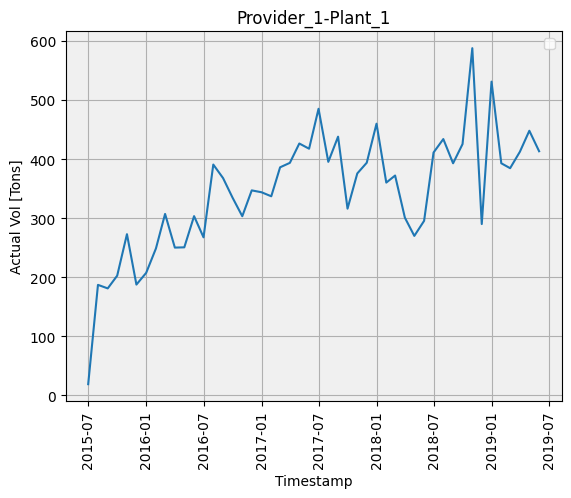

<Figure size 1200x500 with 0 Axes>

In [17]:
ts_key = 'Provider_1-Plant_1'
x_axis = 'Timestamp'
y_axis = 'Actual Vol [Tons]'
_df = df_vol.query(f" ts_key == '{ts_key}'")
x = _df[x_axis]
y = _df[y_axis]

# Create a figure
fig, ax = plt.subplots()

# Create a line plot
plt.rc('text',usetex=False)
plt.figure(figsize=(12, 5))
ax.plot(x, y)

# Add gridlines
ax.grid(True)

# Set a light gray background color
ax.set_facecolor('#f0f0f0') 

# Add labels and a legend
ax.set_xlabel(x_axis)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel(y_axis)
ax.set_title(ts_key)
ax.legend()

# # Show the plot
plt.show()

Now let's crate a plot per timeseries and store it as a PDF. This will allows us to spot patterns, outliers and also to have an easier tool to communicate with the business team.

In [26]:
# Create the PdfPages object to which we will save the pages:
# The with statement makes sure that the PdfPages object is closed properly at
# the end of the block, even if an Exception occurs.
with PdfPages('Timeseries_Tons.pdf') as pdf:
    
    #ts_key = 'Provider_1-Plant_1'
    x_axis = 'Timestamp'
    y_axis = 'Actual Vol [Tons]'
    
    for ts_key in tqdm(df_vol['ts_key'].unique()):
        
        _df = df_vol.query(f" ts_key == '{ts_key}'")
        x = _df[x_axis]
        y = _df[y_axis]

        # Turn off interactive mode
        plt.ioff()
        
        # Activate autolayout so 
        # that the whole plot fits into one page
        plt.rcParams["figure.autolayout"] = True
        
        # Create a figure
        fig, ax = plt.subplots()

        # Create a line plot
        plt.rc('text',usetex=False)
        plt.figure(figsize=(12, 5))

        ax.plot(x, y)
        ax.grid(True)
        ax.set_facecolor('#f0f0f0') 

        # Add labels 
        ax.tick_params(axis='x', rotation=90)
        ax.set_xlabel(x_axis)
        ax.set_ylabel(y_axis)
        ax.set_title(ts_key)
       
        # saves the current figure into a pdf page
        pdf.savefig(fig) 
        plt.close(fig)
        
        del _df

    # We can also set the file's metadata via the PdfPages object:
    d = pdf.infodict()
    d['Title'] = 'Timeseries Tons'
    d['Author'] = 'John Torres'
    d['CreationDate'] = datetime.today()

  0%|          | 0/624 [00:00<?, ?it/s]

  2%|▏         | 10/624 [00:01<01:38,  6.25it/s]/tmp/ipykernel_15623/1362706280.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 5))
  2%|▏         | 11/624 [00:01<01:34,  6.48it/s]/tmp/ipykernel_15623/1362706280.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
100%|██████████| 624/624 [01:42<00:00,  6.10it/s]


## 1.2 Data Analysis

Let's found out the length of every timeseries: 

In [64]:
df_vol['ts_len'] = df_vol.groupby('ts_key')['Timestamp'].transform(lambda x : len(x))

In [65]:
# Create a Summary of all columns
df_vol_summary = df_vol.groupby(['ts_key']).agg(['min','max'])
df_vol_summary.columns = ['-'.join(x) for x in df_vol_summary.columns]
df_vol_summary  = df_vol_summary.reset_index()

In [66]:
df_vol_summary.head()

,ts_key,Timestamp-min,Timestamp-max,Provider-min,Provider-max,Plant-min,Plant-max,Actual Vol [Kg]-min,Actual Vol [Kg]-max,Expected Vol [Kg]-min,...,Year-min,Year-max,Month-min,Month-max,Actual Vol [Tons]-min,Actual Vol [Tons]-max,Expected Vol [Tons]-min,Expected Vol [Tons]-max,ts_len-min,ts_len-max
0,Provider_1-Plant_1,2015-07-01,2019-06-01,Provider_1,Provider_1,Plant_1,Plant_1,19096.0,587616.0,20298.000,...,2015,2019,1,12,19.096,587.616,20.298,531.722,48,48
1,Provider_1-Plant_10,2014-01-01,2019-06-01,Provider_1,Provider_1,Plant_10,Plant_10,18723.0,125475.0,0.000,...,2014,2019,1,12,18.723,125.475,0.000,118.139,66,66
2,Provider_1-Plant_11,2015-01-01,2019-06-01,Provider_1,Provider_1,Plant_11,Plant_11,3649.0,335834.0,13373.000,...,2015,2019,1,12,3.649,335.834,13.373,298.463,48,48
3,Provider_1-Plant_12,2014-01-01,2019-06-01,Provider_1,Provider_1,Plant_12,Plant_12,224448.0,603847.0,217346.995,...,2014,2019,1,12,224.448,603.847,217.347,542.661,66,66
4,Provider_1-Plant_13,2014-01-01,2019-06-01,Provider_1,Provider_1,Plant_13,Plant_13,158588.0,1173034.0,154686.111,...,2014,2019,1,12,158.588,1173.034,154.686,1143.231,66,66


In [67]:
print(" The min date available among all timeseries is: ", df_vol_summary['Timestamp-min'].min())
print(" The max date available among all timeseries is: ", df_vol_summary['Timestamp-max'].max())

print(" The min ts length is ", df_vol_summary['ts_len-min'].min())
print(" The max ts length is ", df_vol_summary['ts_len-max'].max())

ts_with_current_data = df_vol_summary[df_vol_summary['Timestamp-max']==df_vol_summary['Timestamp-max'].max()]['ts_key'].nunique()
print(" Number of time series with data until October 2022: ",  ts_with_current_data)
print(" Number of Total Time Series Available: ", df_vol_summary['ts_key'].nunique() )
print(" Number of Total Time Series Available: ", np.round( ts_with_current_data / df_vol_summary['ts_key'].nunique(), 2 ) * 100, " %"  )

 The min date available among all timeseries is:  2014-01-01 00:00:00
 The max date available among all timeseries is:  2022-10-01 00:00:00
 The min ts length is  1
 The max ts length is  113
 Number of time series with data until October 2022:  306
 Number of Total Time Series Available:  624
 Number of Total Time Series Available:  49.0  %


## 1.3 Data Filtering

Since we found out that out only 49% of all timeseries are available at the last max date. Those are the timeseries which will be relevant for forecasting, otherwise indicated by the business team. We will therefore focused on thos timeseries from now on to analyse their patterns and create the forecast.

In [70]:
valid_ts = df_vol_summary[df_vol_summary['Timestamp-max']==df_vol_summary['Timestamp-max'].max()]['ts_key'].unique()

# Now we just keep those valid timeseries from the data 
# we overwrite our dataset
df_vol = df_vol[df_vol['ts_key'].isin(valid_ts)].copy()

In [75]:
# We just verify our filter was made correctly
# We validate that all ts_key in our new df_vol
# are the same as the one in the list valid_ts
assert set(df_vol['ts_key'].unique()) == set(valid_ts), "There are missing timeseries"

print("Number of available timeseries after filtering", df_vol['ts_key'].nunique())

Number of available timeseries after filtering 306


Now let's check for max and min ts length

In [78]:
print(" The min ts length is ", df_vol['ts_len'].min())
print(" The max ts length is ", df_vol['ts_len'].max())
print(" The mean ts length is ", df_vol['ts_len'].mean())

 The min ts length is  1
 The max ts length is  113
 The mean ts length is  97.5268455014001


Then, together with the Business Area we will define a threshold for which forecast can be generated for a model, in this case, we will select 8, which is 2 times the target horizon we want to forecast for. Anything below that threshold will be forecast by a rule-based method.

In [85]:
ts_len_threshold = 8
remaining_ts = df_vol[df_vol['ts_len']> ts_len_threshold]['ts_key'].nunique()
print(" TS to forecast with Models", remaining_ts)
print(" TS to forecast with Models", np.round(remaining_ts / len(valid_ts), 2) *100 , " %")

 TS to forecast with Models 266
 TS to forecast with Models 87.0  %


## 1.4 Data Completeness

There is another edge case, which can appear in this kind of data. Since this is monthly incoming volume into the plants. There are providers which might deliver multiple time during a month. Causing that for some months we have multiple entries, like this case:

In [110]:
df_vol[(df_vol['ts_key'] == 'Provider_27-Plant_19') & (df_vol['Timestamp'] == '2014-11-01')].head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Year,Month,ts_key,Actual Vol [Tons],Expected Vol [Tons],ts_len
22462,2014-11-01,Provider_27,Plant_19,2680.0,5649.0,2014,11,Provider_27-Plant_19,2.680,5.649,113
22463,2014-11-01,Provider_27,Plant_19,2680.0,1167473.0,2014,11,Provider_27-Plant_19,2.680,1167.473,113
22464,2014-11-01,Provider_27,Plant_19,1161028.0,5649.0,2014,11,Provider_27-Plant_19,1161.028,5.649,113
22465,2014-11-01,Provider_27,Plant_19,1161028.0,1167473.0,2014,11,Provider_27-Plant_19,1161.028,1167.473,113
22466,2014-11-01,Provider_27,Plant_19,2680.0,5649.0,2014,11,Provider_27-Plant_19,2.680,5.649,113


In this case we would have to discuss again with the business team. The solution is just to add up all entries to one month. We can verify for how many timeseries we encounter this case, like this:

In [115]:
# The idea is the for every 'Timestamp','ts_key' combination 
# there should be only one entry for the column 'Actual Vol [Kg]'
df_vol_validator  = (df_vol[['Timestamp','ts_key', 'Actual Vol [Kg]']]
                            .groupby(['Timestamp','ts_key'])
                            .count()
                            .rename(columns = {'Actual Vol [Kg]': 'n_values'})
                            .reset_index())

In [116]:
df_vol_validator.head()

,Timestamp,ts_key,n_values
0,2014-01-01,Provider_10-Plant_10,1
1,2014-01-01,Provider_10-Plant_11,1
2,2014-01-01,Provider_10-Plant_12,1
3,2014-01-01,Provider_10-Plant_13,1
4,2014-01-01,Provider_10-Plant_14,1


Invalid entries will have n_values > 1. 

In [117]:
df_vol_validator[df_vol_validator['n_values'] > 1].head()

,Timestamp,ts_key,n_values
1920,2014-11-01,Provider_27-Plant_19,8


In this case we only found one case. However, this is another important example on how to verify data completeness. Let's now add up all those entries to a single row for both the columns `Actual Vol [Tons]` abd `Expected Vol [Tons]`.

In [134]:
df_vol_c = (df_vol[['Timestamp','ts_key', 'Actual Vol [Tons]','Expected Vol [Tons]']]
                              .groupby(['Timestamp','ts_key'], group_keys=False)
                              .agg({'Actual Vol [Tons]': sum, 
                                    'Expected Vol [Tons]': sum,
                                    })
                              .reset_index()
                              .set_index('Timestamp')
                              )

Now we will make sure that all timeseries are complete, i.e. any missing datapoint inbetween should be filled up. Later when applying data preprocessing, we can apply different methods to interpolate those missing values. 

In [159]:
ts = pd.DataFrame()

for ts_key in tqdm(df_vol_c["ts_key"].unique()[:3]):
    # build custom date range for timeseries   
    idx = pd.date_range(
        start=df_vol_c[df_vol_c["ts_key"] == ts_key].index.min(),
        end=df_vol_c.index.max(),
        # ref: https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases'
        freq="MS", # Start of month 
        name="Date",
    )

    # fill holes in time series
    df = df_vol_c.loc[df_vol_c["ts_key"] == ts_key].reindex(idx)
    df.fillna(
        {
            "ts_key": ts_key,
            "Actual Vol [Tons]": 0,
            "Expected Vol [Tons]": 0,
        },
        inplace=True,
    )
    df["Actual Vol [Tons]"] = df["Actual Vol [Tons]"].astype(np.float32)
    df["Expected Vol [Tons]"] = df["Actual Vol [Tons]"].astype(np.float32)

    if ts.empty:
        ts = df
    else:
        ts = pd.concat([ts, df])
    
    del df

100%|██████████| 3/3 [00:00<00:00, 139.90it/s]


In [160]:
ts.head()

,ts_key,Actual Vol [Tons],Expected Vol [Tons]
Date,,,
2014-01-01,Provider_10-Plant_10,476.199005,476.199005
2014-02-01,Provider_10-Plant_10,388.113007,388.113007
2014-03-01,Provider_10-Plant_10,527.382996,527.382996
2014-04-01,Provider_10-Plant_10,470.321991,470.321991
2014-05-01,Provider_10-Plant_10,500.139008,500.139008


# Production Data

In [27]:
df_prod = pd.read_csv("../data/production_data.csv", index_col=0)

In [29]:
# Convert the Timestamp to a Datetime Object
df_prod['Year'] = df_prod['Timestamp'].apply(lambda x: x.split('/')[0]).astype(int)
df_prod['Month'] = df_prod['Timestamp'].apply(lambda x: x.split('/')[1]).astype(int)
df_prod['Timestamp'] = df_prod[['Year', 'Month']].apply(lambda x: datetime(x['Year'], x['Month'], 1), axis = 1)

,Timestamp,Plant_6,Plant_9,Plant_13,Plant_15,Plant_17,Plant_19,Plant_21,Plant_11,Plant_4,Plant_12,Plant_20,Plant_14,Plant_22,Plant_1,Plant_3,Plant_5,Plant_18,Plant_10
0,2014/01,11848,54138,33839,19438,6770,29098,45147,8578,326919,11668,93855,68067,13127,26363,26363,5799,13749,3633
1,2014/02,13528,53063,36690,24252,6943,26975,42656,9739,334540,11275,92865,66012,18565,29822,29822,7978,12880,2880
2,2014/03,12753,50551,38211,24978,7695,28991,46226,10619,356075,12306,99860,71251,19505,28915,28915,8149,13348,4165
3,2014/04,12681,52528,36979,23872,7436,27409,47929,10379,351736,11790,95409,66233,23983,29441,29441,5020,15650,4457
4,2014/05,13272,50855,31164,24145,7415,27959,47255,12155,332888,10407,97371,69890,21139,28110,28110,7087,15940,4035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023/08,15454,50955,29891,20690,9052,33062,49145,18648,287886,74,56419,60883,91993,82447,82447,2540,15544,2061
116,2023/09,14836,59383,28009,25502,9559,30835,49281,17369,303804,675,59258,74728,105691,76036,76036,15022,13612,6111
117,2023/10,15411,57098,28649,25352,8825,26258,51216,17161,302369,1073,45348,73501,109123,80311,80311,15507,14036,5778
118,2023/11,15787,59564,29065,26150,8866,33834,50791,17353,333637,2508,61175,82960,103552,68576,68576,15256,13650,6332


In [32]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 0 to 119
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  120 non-null    datetime64[ns]
 1   Plant_6    120 non-null    int64         
 2   Plant_9    120 non-null    int64         
 3   Plant_13   120 non-null    int64         
 4   Plant_15   120 non-null    int64         
 5   Plant_17   120 non-null    int64         
 6   Plant_19   120 non-null    int64         
 7   Plant_21   120 non-null    int64         
 8   Plant_11   120 non-null    int64         
 9   Plant_4    120 non-null    int64         
 10  Plant_12   120 non-null    int64         
 11  Plant_20   120 non-null    int64         
 12  Plant_14   120 non-null    int64         
 13  Plant_22   120 non-null    int64         
 14  Plant_1    120 non-null    int64         
 15  Plant_3    120 non-null    int64         
 16  Plant_5    120 non-null    int64         
 17  Pl